# Import Libraries

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Permission Warning 방지
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c playground-series-s4e8

100% 82.3M/82.3M [00:05<00:00, 20.2MB/s]
100% 82.3M/82.3M [00:05<00:00, 15.3MB/s]


In [ ]:
!pip install --upgrade catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 11.6 MB/s eta 0:00:00


In [ ]:
!mkdir -p /etc/OpenCL/vendors && echo "libnvidia-opencl.so.1" > /etc/OpenCL/vendors/nvidia.icd
# https://www.kaggle.com/code/kirankunapuli/ieee-fraud-lightgbm-with-gpu/notebook

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score, cross_validate
from sklearn.metrics import matthews_corrcoef, f1_score, confusion_matrix, ConfusionMatrixDisplay, make_scorer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy.stats import mode

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

# Loading Data

In [ ]:
!unzip /content/playground-series-s4e8.zip

Archive:  /content/playground-series-s4e8.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
train_df = pd.read_csv("/content/train.csv", index_col='id')
orig_df = pd.read_csv("/content/secondary_data.csv", sep=";")
test_df = pd.read_csv("/content/test.csv", index_col='id')

In [ ]:
train_df = pd.concat([train_df, orig_df], ignore_index=True)

In [ ]:
train_df.head()

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,e,8.80,f,s,u,f,a,c,w,4.51,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,a
1,p,4.51,x,h,o,f,a,c,n,4.79,...,NaN,y,o,NaN,NaN,t,z,NaN,d,w
2,e,6.94,f,s,b,f,x,c,w,6.85,...,NaN,s,n,NaN,NaN,f,f,NaN,l,w
3,e,3.88,f,y,g,f,s,NaN,g,4.16,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,u
4,e,5.85,x,l,w,f,d,NaN,w,3.37,...,NaN,NaN,w,NaN,NaN,f,f,NaN,g,a


In [ ]:
test_df.head()

,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
id,,,,,,,,,,,,,,,,,,,,
3116945,8.64,x,NaN,n,t,NaN,NaN,w,11.13,17.12,b,NaN,w,u,w,t,g,NaN,d,a
3116946,6.90,o,t,o,f,NaN,c,y,1.27,10.75,NaN,NaN,n,NaN,NaN,f,f,NaN,d,a
3116947,2.00,b,g,n,f,NaN,c,n,6.18,3.14,NaN,NaN,n,NaN,NaN,f,f,NaN,d,s
3116948,3.47,x,t,n,f,s,c,n,4.98,8.51,NaN,NaN,w,NaN,n,t,z,NaN,d,u
3116949,6.17,x,h,y,f,p,NaN,y,6.73,13.70,NaN,NaN,y,NaN,y,t,NaN,NaN,d,u


# EDA

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3178014 entries, 0 to 3178013
Data columns (total 21 columns):
 #   Column                Dtype  
---  ------                -----  
 0   class                 object 
 1   cap-diameter          float64
 2   cap-shape             object 
 3   cap-surface           object 
 4   cap-color             object 
 5   does-bruise-or-bleed  object 
 6   gill-attachment       object 
 7   gill-spacing          object 
 8   gill-color            object 
 9   stem-height           float64
 10  stem-width            float64
 11  stem-root             object 
 12  stem-surface          object 
 13  stem-color            object 
 14  veil-type             object 
 15  veil-color            object 
 16  has-ring              object 
 17  ring-type             object 
 18  spore-print-color     object 
 19  habitat               object 
 20  season                object 
dtypes: float64(3), object(18)
memory usage: 509.2+ MB


In [ ]:
pd.DataFrame({
    'column': train_df.columns,
    'null-count': train_df.isna().sum().values,
    '% null-count': np.round(train_df.isna().sum().values*100/len(train_df),6)
}).sort_values(by='null-count', ascending=False).reset_index(drop=True)

,column,null-count,% null-count
0,veil-type,3015385,94.882685
1,spore-print-color,2904397,91.390315
2,stem-root,2808561,88.374721
3,veil-color,2794603,87.935516
4,stem-surface,2018985,63.529770
5,gill-spacing,1283498,40.386795
6,cap-surface,685143,21.558841
7,gill-attachment,533820,16.797283
8,ring-type,131351,4.133116
9,gill-color,57,0.001794


In [ ]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
cap-diameter,3178010.0,6.317996,4.670698,0.03,3.32,5.75,8.24,80.67
stem-height,3178014.0,6.352815,2.714383,0.00,4.67,5.88,7.41,88.72
stem-width,3178014.0,11.172917,8.138274,0.00,4.97,9.66,15.65,103.91


In [ ]:
train_df.describe(include='O').T

,count,unique,top,freq
class,3178014,2,p,1739284
cap-shape,3177974,74,x,1462960
cap-surface,2492871,83,t,468973
cap-color,3178002,78,n,1383760
does-bruise-or-bleed,3178006,26,f,2620222
gill-attachment,2644194,78,a,658732
gill-spacing,1894516,48,c,1355764
gill-color,3177957,63,w,950059
stem-root,369453,38,b,168978
stem-surface,1159029,60,s,333635


In [ ]:
train_df.duplicated().sum()

146

In [ ]:
train_df.drop_duplicates(inplace=True)

In [ ]:
target = 'class'

In [ ]:
features = train_df.drop(target, axis=1).columns.to_list()
features

['cap-diameter',
 'cap-shape',
 'cap-surface',
 'cap-color',
 'does-bruise-or-bleed',
 'gill-attachment',
 'gill-spacing',
 'gill-color',
 'stem-height',
 'stem-width',
 'stem-root',
 'stem-surface',
 'stem-color',
 'veil-type',
 'veil-color',
 'has-ring',
 'ring-type',
 'spore-print-color',
 'habitat',
 'season']

In [ ]:
features_with_high_null_values = [feature for feature in features if (train_df[feature].isna().sum()/len(train_df)*100)>20]
features_with_high_null_values

['cap-surface',
 'gill-spacing',
 'stem-root',
 'stem-surface',
 'veil-type',
 'veil-color',
 'spore-print-color']

In [ ]:
categorical_features = train_df[features].select_dtypes(include='object').columns.to_list()
categorical_features

['cap-shape',
 'cap-surface',
 'cap-color',
 'does-bruise-or-bleed',
 'gill-attachment',
 'gill-spacing',
 'gill-color',
 'stem-root',
 'stem-surface',
 'stem-color',
 'veil-type',
 'veil-color',
 'has-ring',
 'ring-type',
 'spore-print-color',
 'habitat',
 'season']

In [ ]:
numerical_features = list(set(features) - set(categorical_features))
numerical_features

['stem-width', 'cap-diameter', 'stem-height']

In [ ]:
pd.concat([train_df, test_df])[categorical_features].describe(include='O').T

,count,unique,top,freq
cap-shape,5255761,108,x,2420907
cap-surface,4123785,114,t,775813
cap-color,5255807,109,n,2288054
does-bruise-or-bleed,5255814,29,f,4333738
gill-attachment,4372220,117,a,1089691
gill-spacing,3132740,66,c,2242712
gill-color,5255726,86,w,1570803
stem-root,609261,45,b,279559
stem-surface,1915361,87,s,552131
stem-color,5255773,88,w,2016928


# Imputing Null Values

## Mean

In [ ]:
def cleaner(df):
    for col in categorical_features:
        df[col] = df[col].fillna('missing')
        df.loc[df[col].value_counts(dropna=False)[df[col]].values < 100, col] = "noise"
        df[col] = df[col].astype('category')

    return df

In [ ]:
## Mean
train_df_mean = cleaner(train_df)
test_df_mean = cleaner(test_df)
cap_diameter_mean = pd.concat([train_df['cap-diameter'], test_df['cap-diameter']]).mean(numeric_only=True)
train_df_mean['cap-diameter'].fillna(cap_diameter_mean, inplace=True)
test_df_mean['cap-diameter'].fillna(cap_diameter_mean, inplace=True)

In [ ]:
X = train_df_mean.copy()
y = X.pop(target)

lab_enc = LabelEncoder().fit(y)
y = lab_enc.transform(y)

In [ ]:
def model_report(estimator, X, y, cv=5):
    print("="*80)
    print(f"    Model: {estimator.__class__.__name__}")
    print("="*80)

    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=1/cv, shuffle=True, stratify=y, random_state=42)

    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)
    print(f"F1 Score : {f1.mean():.6f}")
    print(f"MCC Score: {mcc.mean():.6f}")

    ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()
    plt.title("Confusion Matrix")
    plt.show()

    print()

In [ ]:
def model_trainer(model, X, y, n_splits=5, random_state=42):
    skfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    oof_probs, oof_mccs = [], []
    print("="*80)
    print(f"Training {model.__class__.__name__}")
    print("="*80, end="\n")
    for fold, (train_idx, test_idx) in enumerate(skfold.split(X, y)):
        X_train, y_train = X.iloc[train_idx, :], y[train_idx]
        X_test, y_test = X.iloc[test_idx, :], y[test_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        mcc = matthews_corrcoef(y_pred, y_test)
        oof_mccs.append(mcc)
        oof_probs.append(model.predict_proba(test_df_mean))
        print(f"--- Fold {fold+1} MCC Score: {mcc:.6f}")
    print(f"\n---> Mean MCC Score: {np.mean(oof_mccs):.6f} \xb1 {np.std(oof_mccs):.6f}\n\n")
    return oof_probs, oof_mccs

    Model: XGBClassifier
F1 Score : 0.992520
MCC Score: 0.983502


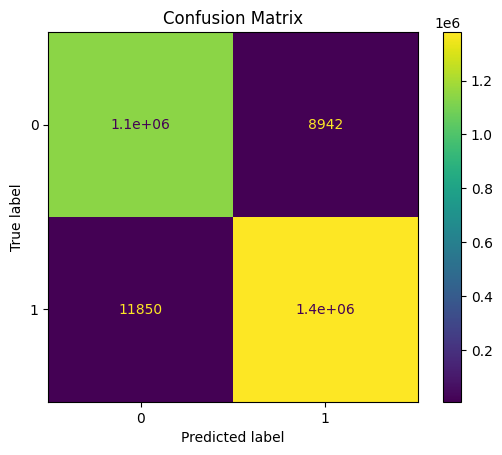

In [ ]:
xgb_clf = XGBClassifier(enable_categorical=True, device="cuda", tree_method="hist")

model_report(xgb_clf, X, y)

In [ ]:
cat_clf = CatBoostClassifier(
    cat_features=categorical_features,
    verbose=False,
    allow_writing_files=False,
    task_type="GPU"
)

model_report(cat_clf, X, y)

    Model: CatBoostClassifier


In [ ]:
lgb_clf = LGBMClassifier(device='gpu', verbosity=-1)

model_report(lgb_clf, X, y)

In [ ]:
xgb_params = {
    'n_estimators': 2407,
    'eta': 0.009462133032592785,
    'gamma': 0.2865859948765318,
    'max_depth': 31,
    'min_child_weight': 47,
    'subsample': 0.6956431754146083,
    'colsample_bytree': 0.3670732604094118,
    'grow_policy': 'lossguide',
    'max_leaves': 73,
    'enable_categorical': True,
    'n_jobs': -1,
    'device': 'cuda',
    'tree_method': 'hist'
} # 0.9844272567086021

cat_params = {
    'iterations': 1041,
    'learning_rate': 0.08777255350163136,
    'depth': 10,
    'l2_leaf_reg': 0.1259643500248322,
    'bootstrap_type': 'Bayesian',
    'random_strength': 4.276181166674371e-08,
    'bagging_temperature': 0.35995482350907326,
    'od_type': 'Iter',
    'od_wait': 39,
    "verbose": False,
    "allow_writing_files": False,
    "task_type": 'GPU',
    "cat_features": categorical_features
} # 0.9841773055825763

lgb_params = {
    'n_estimators': 2500,
    'random_state':42,
    'max_bin':1024,
    'colsample_bytree':0.6,
    'reg_lambda': 80,
#     'device': 'gpu',
    'verbosity': -1
}

In [ ]:
oof_probs = {}
oof_probs['xgb'], _ = model_trainer(XGBClassifier(**xgb_params), X, y, random_state=101)
# oof_probs['cat'], _ = model_trainer(CatBoostClassifier(**cat_params), X, y, random_state=101)
# oof_probs['lgb'], _ = model_trainer(LGBMClassifier(**lgb_params), X, y, random_state=101)

In [ ]:
oof_preds = {}
for model in oof_probs.keys():
    oof_preds[model] = np.argmax(np.mean(oof_probs[model], axis=0), axis=1)

## Median

In [ ]:
## 중앙값으로 대체
def cleaner_median(df, numerical_features):
    for col in categorical_features:
        df[col] = df[col].fillna('missing')
        df.loc[df[col].value_counts(dropna=False)[df[col]].values < 100, col] = "noise"
        df[col] = df[col].astype('category')

    for col in numerical_features:
        df[col] = df[col].fillna(df[col].median())

    return df

train_df_median = cleaner_median(train_df, numerical_features)
test_df_median = cleaner_median(test_df, numerical_features)

In [ ]:
X = train_df_median.copy()
y = X.pop(target)

lab_enc = LabelEncoder().fit(y)
y = lab_enc.transform(y)

In [ ]:
def model_report(estimator, X, y, cv=5):
    print("="*80)
    print(f"    Model: {estimator.__class__.__name__}")
    print("="*80)

    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=1/cv, shuffle=True, stratify=y, random_state=42)

    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)
    print(f"F1 Score : {f1.mean():.6f}")
    print(f"MCC Score: {mcc.mean():.6f}")

    ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()
    plt.title("Confusion Matrix")
    plt.show()

    print()

In [ ]:
def model_trainer(model, X, y, n_splits=5, random_state=42):
    skfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    oof_probs, oof_mccs = [], []
    print("="*80)
    print(f"Training {model.__class__.__name__}")
    print("="*80, end="\n")
    for fold, (train_idx, test_idx) in enumerate(skfold.split(X, y)):
        X_train, y_train = X.iloc[train_idx, :], y[train_idx]
        X_test, y_test = X.iloc[test_idx, :], y[test_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        mcc = matthews_corrcoef(y_pred, y_test)
        oof_mccs.append(mcc)
        oof_probs.append(model.predict_proba(test_df_median))
        print(f"--- Fold {fold+1} MCC Score: {mcc:.6f}")
    print(f"\n---> Mean MCC Score: {np.mean(oof_mccs):.6f} \xb1 {np.std(oof_mccs):.6f}\n\n")
    return oof_probs, oof_mccs

    Model: XGBClassifier
F1 Score : 0.992520
MCC Score: 0.983502


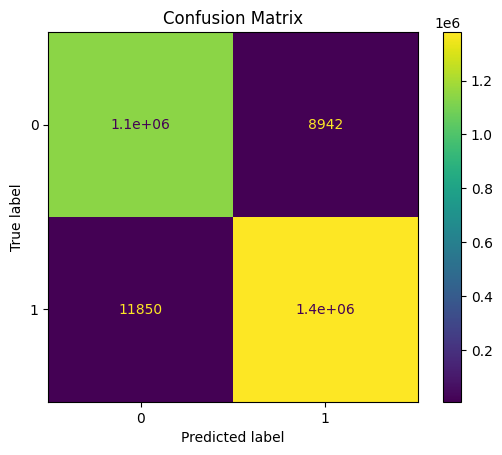

In [ ]:
xgb_clf = XGBClassifier(enable_categorical=True, device="cuda", tree_method="hist")

model_report(xgb_clf, X, y)

    Model: CatBoostClassifier
F1 Score : 0.992283
MCC Score: 0.982976


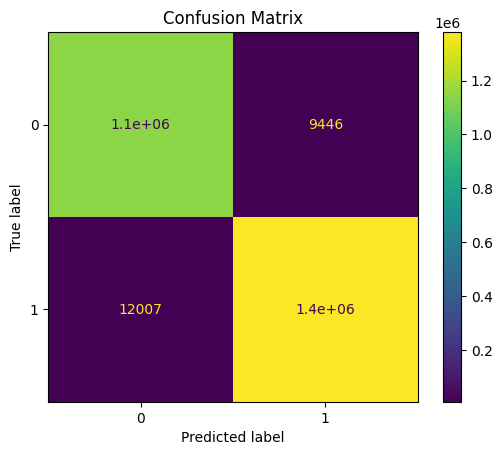

In [ ]:
cat_clf = CatBoostClassifier(
    cat_features=categorical_features,
    verbose=False,
    allow_writing_files=False,
    task_type="GPU"
)

model_report(cat_clf, X, y)

    Model: LGBMClassifier
F1 Score : 0.991484
MCC Score: 0.981226


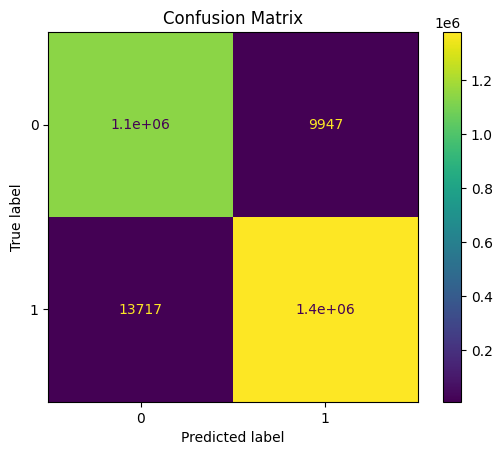

In [ ]:
lgb_clf = LGBMClassifier(device='gpu', verbosity=-1)

model_report(lgb_clf, X, y)

In [ ]:
xgb_params = {
    'n_estimators': 2407,
    'eta': 0.009462133032592785,
    'gamma': 0.2865859948765318,
    'max_depth': 31,
    'min_child_weight': 47,
    'subsample': 0.6956431754146083,
    'colsample_bytree': 0.3670732604094118,
    'grow_policy': 'lossguide',
    'max_leaves': 73,
    'enable_categorical': True,
    'n_jobs': -1,
    'device': 'cuda',
    'tree_method': 'hist'
} # 0.9844272567086021

cat_params = {
    'iterations': 1041,
    'learning_rate': 0.08777255350163136,
    'depth': 10,
    'l2_leaf_reg': 0.1259643500248322,
    'bootstrap_type': 'Bayesian',
    'random_strength': 4.276181166674371e-08,
    'bagging_temperature': 0.35995482350907326,
    'od_type': 'Iter',
    'od_wait': 39,
    "verbose": False,
    "allow_writing_files": False,
    "task_type": 'GPU',
    "cat_features": categorical_features
} # 0.9841773055825763

lgb_params = {
    'n_estimators': 2500,
    'random_state':42,
    'max_bin':1024,
    'colsample_bytree':0.6,
    'reg_lambda': 80,
#     'device': 'gpu',
    'verbosity': -1
}

In [ ]:
oof_probs = {}
oof_probs['xgb'], _ = model_trainer(XGBClassifier(**xgb_params), X, y, random_state=101)
# oof_probs['cat'], _ = model_trainer(CatBoostClassifier(**cat_params), X, y, random_state=101)
# oof_probs['lgb'], _ = model_trainer(LGBMClassifier(**lgb_params), X, y, random_state=101)

In [ ]:
oof_preds = {}
for model in oof_probs.keys():
    oof_preds[model] = np.argmax(np.mean(oof_probs[model], axis=0), axis=1)

## Mode

In [ ]:
## 최빈값으로 대체
def cleaner_mode(df, numerical_features):
  for col in categorical_features:
    df[col] = df[col].fillna('missing')
    df.loc[df[col].value_counts(dropna=False)[df[col]].values < 100, col] = "noise"
    df[col] = df[col].astype('category')

  for col in numerical_features:
    df[col] = df[col].fillna(df[col].mode()[0])

    return df

train_df_mode = cleaner_mode(train_df, numerical_features)
test_df_mode = cleaner_mode(test_df, numerical_features)

In [ ]:
X = train_df_mode.copy()
y = X.pop(target)

lab_enc = LabelEncoder().fit(y)
y = lab_enc.transform(y)

In [ ]:
def model_report(estimator, X, y, cv=5):
    print("="*80)
    print(f"    Model: {estimator.__class__.__name__}")
    print("="*80)

    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=1/cv, shuffle=True, stratify=y, random_state=42)

    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)
    print(f"F1 Score : {f1.mean():.6f}")
    print(f"MCC Score: {mcc.mean():.6f}")

    ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()
    plt.title("Confusion Matrix")
    plt.show()

    print()

In [ ]:
def model_trainer(model, X, y, n_splits=5, random_state=42):
    skfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    oof_probs, oof_mccs = [], []
    print("="*80)
    print(f"Training {model.__class__.__name__}")
    print("="*80, end="\n")
    for fold, (train_idx, test_idx) in enumerate(skfold.split(X, y)):
        X_train, y_train = X.iloc[train_idx, :], y[train_idx]
        X_test, y_test = X.iloc[test_idx, :], y[test_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        mcc = matthews_corrcoef(y_pred, y_test)
        oof_mccs.append(mcc)
        oof_probs.append(model.predict_proba(test_df_mode))
        print(f"--- Fold {fold+1} MCC Score: {mcc:.6f}")
    print(f"\n---> Mean MCC Score: {np.mean(oof_mccs):.6f} \xb1 {np.std(oof_mccs):.6f}\n\n")
    return oof_probs, oof_mccs

    Model: XGBClassifier
F1 Score : 0.992525
MCC Score: 0.983512


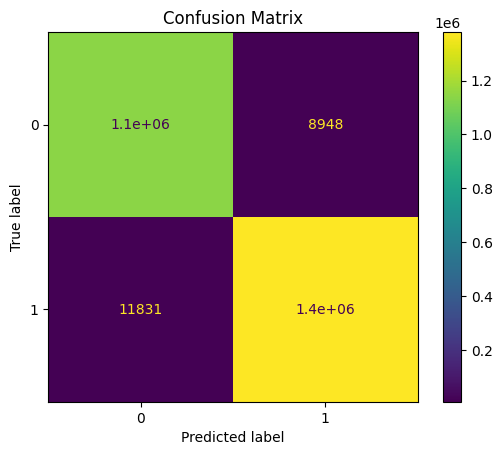

In [ ]:
xgb_clf = XGBClassifier(enable_categorical=True, device="cuda", tree_method="hist")

model_report(xgb_clf, X, y)

    Model: CatBoostClassifier
F1 Score : 0.992280
MCC Score: 0.982969


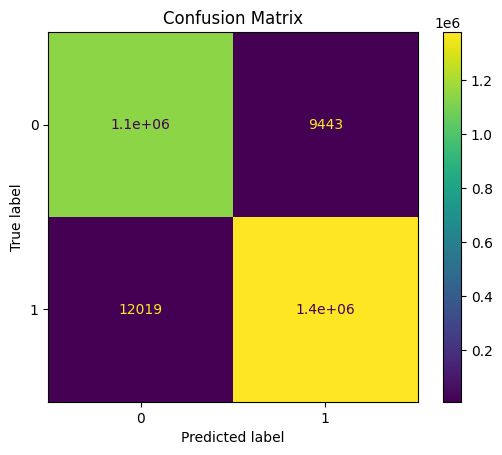

In [ ]:
cat_clf = CatBoostClassifier(
    cat_features=categorical_features,
    verbose=False,
    allow_writing_files=False,
    task_type="GPU"
)

model_report(cat_clf, X, y)

    Model: LGBMClassifier
F1 Score : 0.991484
MCC Score: 0.981226


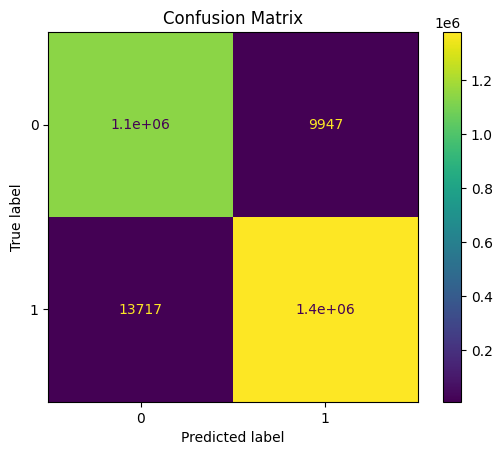

In [ ]:
lgb_clf = LGBMClassifier(device='gpu', verbosity=-1)

model_report(lgb_clf, X, y)

In [ ]:
xgb_params = {
    'n_estimators': 2407,
    'eta': 0.009462133032592785,
    'gamma': 0.2865859948765318,
    'max_depth': 31,
    'min_child_weight': 47,
    'subsample': 0.6956431754146083,
    'colsample_bytree': 0.3670732604094118,
    'grow_policy': 'lossguide',
    'max_leaves': 73,
    'enable_categorical': True,
    'n_jobs': -1,
    'device': 'cuda',
    'tree_method': 'hist'
} # 0.9844272567086021

cat_params = {
    'iterations': 1041,
    'learning_rate': 0.08777255350163136,
    'depth': 10,
    'l2_leaf_reg': 0.1259643500248322,
    'bootstrap_type': 'Bayesian',
    'random_strength': 4.276181166674371e-08,
    'bagging_temperature': 0.35995482350907326,
    'od_type': 'Iter',
    'od_wait': 39,
    "verbose": False,
    "allow_writing_files": False,
    "task_type": 'GPU',
    "cat_features": categorical_features
} # 0.9841773055825763

lgb_params = {
    'n_estimators': 2500,
    'random_state':42,
    'max_bin':1024,
    'colsample_bytree':0.6,
    'reg_lambda': 80,
#     'device': 'gpu',
    'verbosity': -1
}

In [ ]:
oof_probs = {}
oof_probs['xgb'], _ = model_trainer(XGBClassifier(**xgb_params), X, y, random_state=101)
# oof_probs['cat'], _ = model_trainer(CatBoostClassifier(**cat_params), X, y, random_state=101)
# oof_probs['lgb'], _ = model_trainer(LGBMClassifier(**lgb_params), X, y, random_state=101)

In [ ]:
oof_preds = {}
for model in oof_probs.keys():
    oof_preds[model] = np.argmax(np.mean(oof_probs[model], axis=0), axis=1)

## Regression

In [ ]:
## 선형회귀로 대체
from sklearn.linear_model import LinearRegression

def cleaner_regression(df, numerical_features):
    for col in categorical_features:
        df[col] = df[col].fillna('missing')
        noise_mask = df[col].map(df[col].value_counts(dropna=False)) < 100
        df.loc[noise_mask, col] = "noise"
        df[col] = df[col].astype('category')

    for col in numerical_features:
        if df[col].isnull().sum() > 0:
            other_cols = df.drop(columns=[col]).select_dtypes(include=['number']).columns

            other_cols = [c for c in other_cols if df[c].isnull().sum() == 0]

            not_null_data = df[df[col].notnull()]
            null_data = df[df[col].isnull()]

            X_train = not_null_data[other_cols]
            y_train = not_null_data[col]

            model = LinearRegression()
            model.fit(X_train, y_train)

            df.loc[df[col].isnull(), col] = model.predict(null_data[other_cols])

    return df

train_df_regression = cleaner_regression(train_df, numerical_features)
test_df_regression = cleaner_regression(test_df, numerical_features)


In [ ]:
X = train_df_regression.copy()
y = X.pop(target)

lab_enc = LabelEncoder().fit(y)
y = lab_enc.transform(y)

In [ ]:
def model_report(estimator, X, y, cv=5):
    print("="*80)
    print(f"    Model: {estimator.__class__.__name__}")
    print("="*80)

    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=1/cv, shuffle=True, stratify=y, random_state=42)

    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)
    print(f"F1 Score : {f1.mean():.6f}")
    print(f"MCC Score: {mcc.mean():.6f}")

    ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()
    plt.title("Confusion Matrix")
    plt.show()

    print()

In [ ]:
def model_trainer(model, X, y, n_splits=5, random_state=42):
    skfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    oof_probs, oof_mccs = [], []
    print("="*80)
    print(f"Training {model.__class__.__name__}")
    print("="*80, end="\n")
    for fold, (train_idx, test_idx) in enumerate(skfold.split(X, y)):
        X_train, y_train = X.iloc[train_idx, :], y[train_idx]
        X_test, y_test = X.iloc[test_idx, :], y[test_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        mcc = matthews_corrcoef(y_pred, y_test)
        oof_mccs.append(mcc)
        oof_probs.append(model.predict_proba(test_df_regression))
        print(f"--- Fold {fold+1} MCC Score: {mcc:.6f}")
    print(f"\n---> Mean MCC Score: {np.mean(oof_mccs):.6f} \xb1 {np.std(oof_mccs):.6f}\n\n")
    return oof_probs, oof_mccs

    Model: XGBClassifier
F1 Score : 0.992520
MCC Score: 0.983502


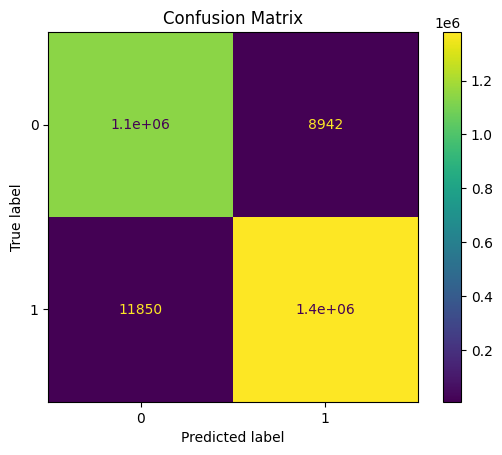

In [ ]:
xgb_clf = XGBClassifier(enable_categorical=True, device="cuda", tree_method="hist")

model_report(xgb_clf, X, y)

    Model: CatBoostClassifier
F1 Score : 0.992276
MCC Score: 0.982960


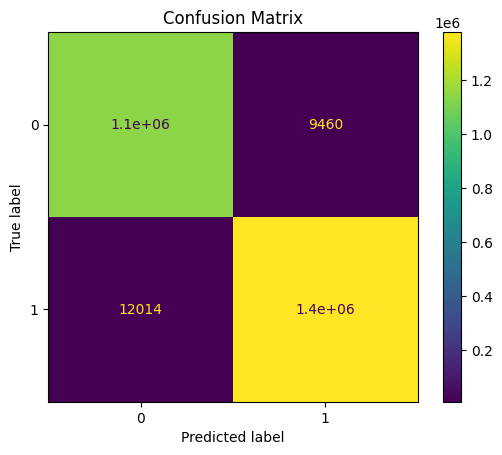

In [ ]:
cat_clf = CatBoostClassifier(
    cat_features=categorical_features,
    verbose=False,
    allow_writing_files=False,
    task_type="GPU"
)

model_report(cat_clf, X, y)

    Model: LGBMClassifier
F1 Score : 0.991484
MCC Score: 0.981226


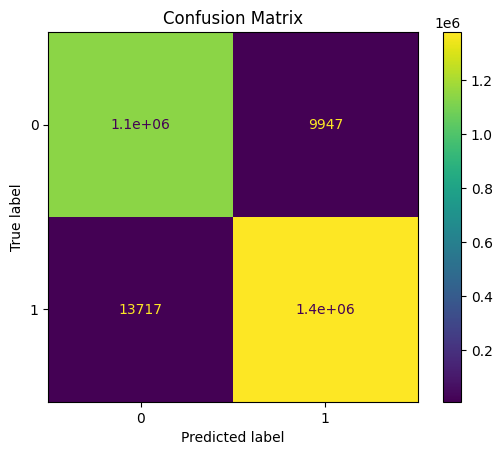

In [ ]:
lgb_clf = LGBMClassifier(device='gpu', verbosity=-1)

model_report(lgb_clf, X, y)

In [ ]:
xgb_params = {
    'n_estimators': 2407,
    'eta': 0.009462133032592785,
    'gamma': 0.2865859948765318,
    'max_depth': 31,
    'min_child_weight': 47,
    'subsample': 0.6956431754146083,
    'colsample_bytree': 0.3670732604094118,
    'grow_policy': 'lossguide',
    'max_leaves': 73,
    'enable_categorical': True,
    'n_jobs': -1,
    'device': 'cuda',
    'tree_method': 'hist'
} # 0.9844272567086021

cat_params = {
    'iterations': 1041,
    'learning_rate': 0.08777255350163136,
    'depth': 10,
    'l2_leaf_reg': 0.1259643500248322,
    'bootstrap_type': 'Bayesian',
    'random_strength': 4.276181166674371e-08,
    'bagging_temperature': 0.35995482350907326,
    'od_type': 'Iter',
    'od_wait': 39,
    "verbose": False,
    "allow_writing_files": False,
    "task_type": 'GPU',
    "cat_features": categorical_features
} # 0.9841773055825763

lgb_params = {
    'n_estimators': 2500,
    'random_state':42,
    'max_bin':1024,
    'colsample_bytree':0.6,
    'reg_lambda': 80,
#     'device': 'gpu',
    'verbosity': -1
}

In [ ]:
oof_probs = {}
oof_probs['xgb'], _ = model_trainer(XGBClassifier(**xgb_params), X, y, random_state=101)
# oof_probs['cat'], _ = model_trainer(CatBoostClassifier(**cat_params), X, y, random_state=101)
# oof_probs['lgb'], _ = model_trainer(LGBMClassifier(**lgb_params), X, y, random_state=101)

In [ ]:
oof_preds = {}
for model in oof_probs.keys():
    oof_preds[model] = np.argmax(np.mean(oof_probs[model], axis=0), axis=1)

## KNN

In [ ]:
## KNN으로 대체
from sklearn.impute import KNNImputer

def cleaner_knn(df, numerical_features, n_neighbors=5):

    for col in categorical_features:
        df[col] = df[col].fillna('missing')
        noise_mask = df[col].map(df[col].value_counts()) < 100
        df.loc[noise_mask, col] = 'noise'
        df[col] = df[col].astype('category')

    imputer = KNNImputer(n_neighbors=n_neighbors)
    df[numerical_features] = imputer.fit_transform(df[numerical_features])

    return df

train_df_knn = cleaner_knn(train_df, numerical_features)
test_df_knn = cleaner_knn(test_df, numerical_features)

In [ ]:
X = train_df_knn.copy()
y = X.pop(target)

lab_enc = LabelEncoder().fit(y)
y = lab_enc.transform(y)

In [ ]:
def model_report(estimator, X, y, cv=5):
    print("="*80)
    print(f"    Model: {estimator.__class__.__name__}")
    print("="*80)

    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=1/cv, shuffle=True, stratify=y, random_state=42)

    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)
    print(f"F1 Score : {f1.mean():.6f}")
    print(f"MCC Score: {mcc.mean():.6f}")

    ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()
    plt.title("Confusion Matrix")
    plt.show()

    print()

In [ ]:
def model_trainer(model, X, y, n_splits=5, random_state=42):
    skfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    oof_probs, oof_mccs = [], []
    print("="*80)
    print(f"Training {model.__class__.__name__}")
    print("="*80, end="\n")
    for fold, (train_idx, test_idx) in enumerate(skfold.split(X, y)):
        X_train, y_train = X.iloc[train_idx, :], y[train_idx]
        X_test, y_test = X.iloc[test_idx, :], y[test_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        mcc = matthews_corrcoef(y_pred, y_test)
        oof_mccs.append(mcc)
        oof_probs.append(model.predict_proba(test_df_knn))
        print(f"--- Fold {fold+1} MCC Score: {mcc:.6f}")
    print(f"\n---> Mean MCC Score: {np.mean(oof_mccs):.6f} \xb1 {np.std(oof_mccs):.6f}\n\n")
    return oof_probs, oof_mccs

    Model: XGBClassifier
F1 Score : 0.992520
MCC Score: 0.983502


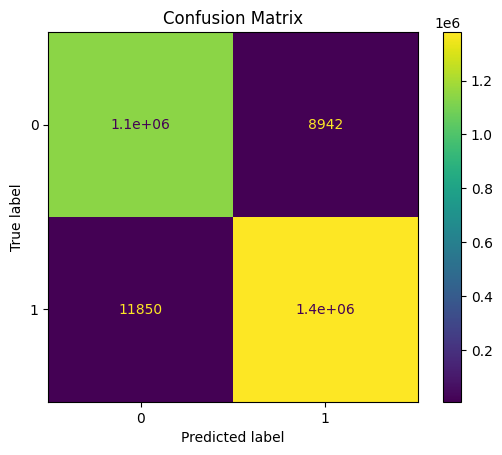

In [ ]:
xgb_clf = XGBClassifier(enable_categorical=True, device="cuda", tree_method="hist")

model_report(xgb_clf, X, y)

    Model: CatBoostClassifier
F1 Score : 0.992276
MCC Score: 0.982960


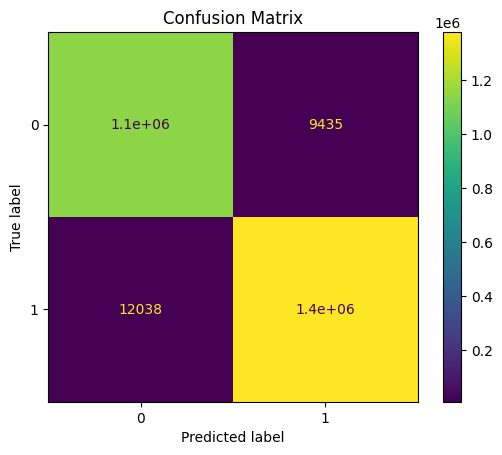

In [ ]:
cat_clf = CatBoostClassifier(
    cat_features=categorical_features,
    verbose=False,
    allow_writing_files=False,
    task_type="GPU"
)

model_report(cat_clf, X, y)

    Model: LGBMClassifier
F1 Score : 0.991484
MCC Score: 0.981226


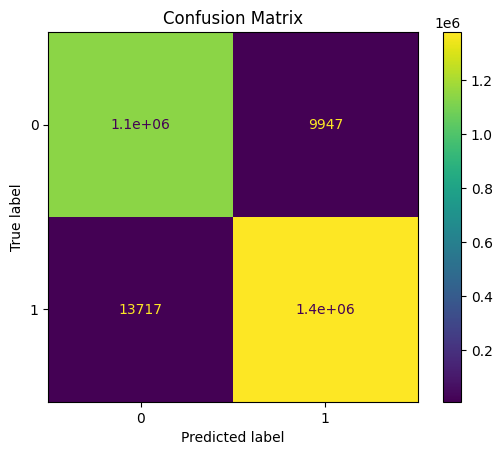

In [ ]:
lgb_clf = LGBMClassifier(device='gpu', verbosity=-1)

model_report(lgb_clf, X, y)

In [ ]:
xgb_params = {
    'n_estimators': 2407,
    'eta': 0.009462133032592785,
    'gamma': 0.2865859948765318,
    'max_depth': 31,
    'min_child_weight': 47,
    'subsample': 0.6956431754146083,
    'colsample_bytree': 0.3670732604094118,
    'grow_policy': 'lossguide',
    'max_leaves': 73,
    'enable_categorical': True,
    'n_jobs': -1,
    'device': 'cuda',
    'tree_method': 'hist'
} # 0.9844272567086021

cat_params = {
    'iterations': 1041,
    'learning_rate': 0.08777255350163136,
    'depth': 10,
    'l2_leaf_reg': 0.1259643500248322,
    'bootstrap_type': 'Bayesian',
    'random_strength': 4.276181166674371e-08,
    'bagging_temperature': 0.35995482350907326,
    'od_type': 'Iter',
    'od_wait': 39,
    "verbose": False,
    "allow_writing_files": False,
    "task_type": 'GPU',
    "cat_features": categorical_features
} # 0.9841773055825763

lgb_params = {
    'n_estimators': 2500,
    'random_state':42,
    'max_bin':1024,
    'colsample_bytree':0.6,
    'reg_lambda': 80,
#     'device': 'gpu',
    'verbosity': -1
}

In [ ]:
oof_probs = {}
oof_probs['xgb'], _ = model_trainer(XGBClassifier(**xgb_params), X, y, random_state=101)
# oof_probs['cat'], _ = model_trainer(CatBoostClassifier(**cat_params), X, y, random_state=101)
# oof_probs['lgb'], _ = model_trainer(LGBMClassifier(**lgb_params), X, y, random_state=101)

In [ ]:
oof_preds = {}
for model in oof_probs.keys():
    oof_preds[model] = np.argmax(np.mean(oof_probs[model], axis=0), axis=1)

## Mode(범주형 데이터도)

In [ ]:
## 최빈값으로 대체
def cleaner_mode(df, categorical_features, numerical_features):
    for col in categorical_features:
        # 범주형 데이터 최빈값으로 처리
        df[col] = df[col].fillna(df[col].mode()[0])

        # noise 처리
        df.loc[df[col].value_counts(dropna=False)[df[col]].values < 100, col] = "noise"
        df[col] = df[col].astype('category')

    for col in numerical_features:
        # 수치형 데이터의 결측치를 최빈값으로 대체
        df[col] = df[col].fillna(df[col].mode()[0])

    return df

# train_df와 test_df에 적용
train_df_mode = cleaner_mode(train_df, categorical_features, numerical_features)
test_df_mode = cleaner_mode(test_df, categorical_features, numerical_features)

In [ ]:
X = train_df_mode.copy()
y = X.pop(target)

lab_enc = LabelEncoder().fit(y)
y = lab_enc.transform(y)

In [ ]:
def model_report(estimator, X, y, cv=5):
    print("="*80)
    print(f"    Model: {estimator.__class__.__name__}")
    print("="*80)

    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=1/cv, shuffle=True, stratify=y, random_state=42)

    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)
    print(f"F1 Score : {f1.mean():.6f}")
    print(f"MCC Score: {mcc.mean():.6f}")

    ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()
    plt.title("Confusion Matrix")
    plt.show()

    print()

In [ ]:
def model_trainer(model, X, y, n_splits=5, random_state=42):
    skfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    oof_probs, oof_mccs = [], []
    print("="*80)
    print(f"Training {model.__class__.__name__}")
    print("="*80, end="\n")
    for fold, (train_idx, test_idx) in enumerate(skfold.split(X, y)):
        X_train, y_train = X.iloc[train_idx, :], y[train_idx]
        X_test, y_test = X.iloc[test_idx, :], y[test_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        mcc = matthews_corrcoef(y_pred, y_test)
        oof_mccs.append(mcc)
        oof_probs.append(model.predict_proba(test_df_mode))
        print(f"--- Fold {fold+1} MCC Score: {mcc:.6f}")
    print(f"\n---> Mean MCC Score: {np.mean(oof_mccs):.6f} \xb1 {np.std(oof_mccs):.6f}\n\n")
    return oof_probs, oof_mccs

    Model: XGBClassifier
F1 Score : 0.991554
MCC Score: 0.981379


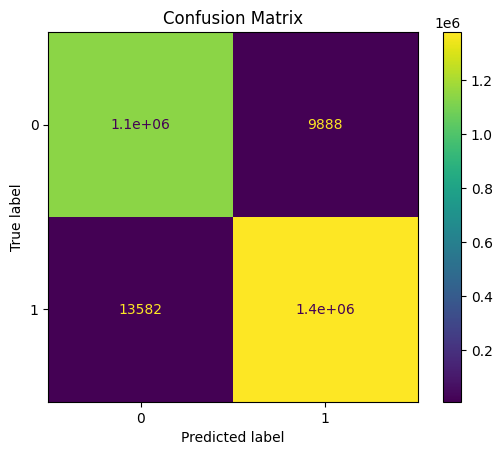

In [ ]:
xgb_clf = XGBClassifier(enable_categorical=True, device="cuda", tree_method="hist")

model_report(xgb_clf, X, y)

    Model: CatBoostClassifier
F1 Score : 0.991007
MCC Score: 0.980174


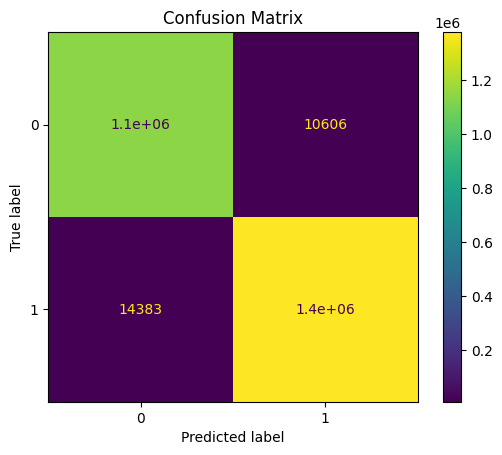

In [ ]:
cat_clf = CatBoostClassifier(
    cat_features=categorical_features,
    verbose=False,
    allow_writing_files=False,
    task_type="GPU"
)

model_report(cat_clf, X, y)

    Model: LGBMClassifier
F1 Score : 0.990339
MCC Score: 0.978713


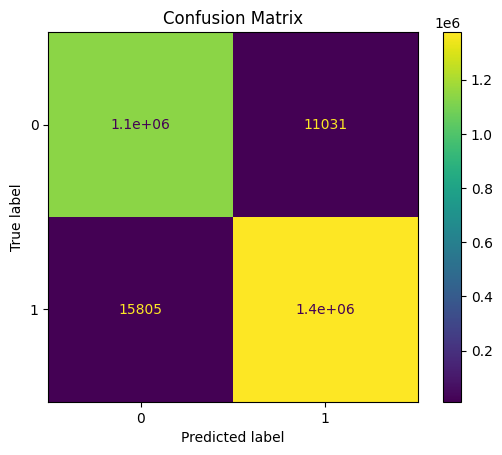

In [ ]:
lgb_clf = LGBMClassifier(device='gpu', verbosity=-1)

model_report(lgb_clf, X, y)

In [ ]:
xgb_params = {
    'n_estimators': 2407,
    'eta': 0.009462133032592785,
    'gamma': 0.2865859948765318,
    'max_depth': 31,
    'min_child_weight': 47,
    'subsample': 0.6956431754146083,
    'colsample_bytree': 0.3670732604094118,
    'grow_policy': 'lossguide',
    'max_leaves': 73,
    'enable_categorical': True,
    'n_jobs': -1,
    'device': 'cuda',
    'tree_method': 'hist'
} # 0.9844272567086021

cat_params = {
    'iterations': 1041,
    'learning_rate': 0.08777255350163136,
    'depth': 10,
    'l2_leaf_reg': 0.1259643500248322,
    'bootstrap_type': 'Bayesian',
    'random_strength': 4.276181166674371e-08,
    'bagging_temperature': 0.35995482350907326,
    'od_type': 'Iter',
    'od_wait': 39,
    "verbose": False,
    "allow_writing_files": False,
    "task_type": 'GPU',
    "cat_features": categorical_features
} # 0.9841773055825763

lgb_params = {
    'n_estimators': 2500,
    'random_state':42,
    'max_bin':1024,
    'colsample_bytree':0.6,
    'reg_lambda': 80,
#     'device': 'gpu',
    'verbosity': -1
}

In [ ]:
oof_probs = {}
oof_probs['xgb'], _ = model_trainer(XGBClassifier(**xgb_params), X, y, random_state=101)
# oof_probs['cat'], _ = model_trainer(CatBoostClassifier(**cat_params), X, y, random_state=101)
# oof_probs['lgb'], _ = model_trainer(LGBMClassifier(**lgb_params), X, y, random_state=101)

In [ ]:
oof_preds = {}
for model in oof_probs.keys():
    oof_preds[model] = np.argmax(np.mean(oof_probs[model], axis=0), axis=1)

# KNN(범주형도)

In [ ]:
# https://gist.github.com/YohanObadia/b310793cd22a4427faaadd9c381a5850
import numpy as np
import pandas as pd
from collections import defaultdict
from scipy.stats import hmean
from scipy.spatial.distance import cdist
from scipy import stats
import numbers


def weighted_hamming(data):
    """ Compute weighted hamming distance on categorical variables. For one variable, it is equal to 1 if
        the values between point A and point B are different, else it is equal the relative frequency of the
        distribution of the value across the variable. For multiple variables, the harmonic mean is computed
        up to a constant factor.
        @params:
            - data = a pandas data frame of categorical variables
        @returns:
            - distance_matrix = a distance matrix with pairwise distance for all attributes
    """
    categories_dist = []

    for category in data:
        X = pd.get_dummies(data[category])
        X_mean = X * X.mean()
        X_dot = X_mean.dot(X.transpose())
        X_np = np.asarray(X_dot.replace(0,1,inplace=False))
        categories_dist.append(X_np)
    categories_dist = np.array(categories_dist)
    distances = hmean(categories_dist, axis=0)
    return distances


def distance_matrix(data, numeric_distance = "euclidean", categorical_distance = "jaccard"):
    """ Compute the pairwise distance attribute by attribute in order to account for different variables type:
        - Continuous
        - Categorical
        For ordinal values, provide a numerical representation taking the order into account.
        Categorical variables are transformed into a set of binary ones.
        If both continuous and categorical distance are provided, a Gower-like distance is computed and the numeric
        variables are all normalized in the process.
        If there are missing values, the mean is computed for numerical attributes and the mode for categorical ones.

        Note: If weighted-hamming distance is chosen, the computation time increases a lot since it is not coded in C
        like other distance metrics provided by scipy.
        @params:
            - data                  = pandas dataframe to compute distances on.
            - numeric_distances     = the metric to apply to continuous attributes.
                                      "euclidean" and "cityblock" available.
                                      Default = "euclidean"
            - categorical_distances = the metric to apply to binary attributes.
                                      "jaccard", "hamming", "weighted-hamming" and "euclidean"
                                      available. Default = "jaccard"
        @returns:
            - the distance matrix
    """
    possible_continuous_distances = ["euclidean", "cityblock"]
    possible_binary_distances = ["euclidean", "jaccard", "hamming", "weighted-hamming"]
    number_of_variables = data.shape[1]
    number_of_observations = data.shape[0]

    # Get the type of each attribute (Numeric or categorical)
    is_numeric = [all(isinstance(n, numbers.Number) for n in data.iloc[:, i]) for i, x in enumerate(data)]
    is_all_numeric = sum(is_numeric) == len(is_numeric)
    is_all_categorical = sum(is_numeric) == 0
    is_mixed_type = not is_all_categorical and not is_all_numeric

# Check the content of the distances parameter
    if numeric_distance not in possible_continuous_distances:
        print("The continuous distance " + numeric_distance + " is not supported.")
        return None
    elif categorical_distance not in possible_binary_distances:
        print("The binary distance " + categorical_distance + " is not supported.")
        return None

    # Separate the data frame into categorical and numeric attributes and normalize numeric data
    if is_mixed_type:
        number_of_numeric_var = sum(is_numeric)
        number_of_categorical_var = number_of_variables - number_of_numeric_var
        data_numeric = data.iloc[:, is_numeric]
        data_numeric = (data_numeric - data_numeric.mean()) / (data_numeric.max() - data_numeric.min())
        data_categorical = data.iloc[:, [not x for x in is_numeric]]

    # Replace missing values with column mean for numeric values and mode for categorical ones. With the mode, it
    # triggers a warning: "SettingWithCopyWarning: A value is trying to be set on a copy of a slice from a DataFrame"
    # but the value are properly replaced
    if is_mixed_type:
        data_numeric.fillna(data_numeric.mean(), inplace=True)
        for x in data_categorical:
            data_categorical[x].fillna(data_categorical[x].mode()[0], inplace=True)
    elif is_all_numeric:
        data.fillna(data.mean(), inplace=True)
    else:
        for x in data:
            data[x].fillna(data[x].mode()[0], inplace=True)

    # "Dummifies" categorical variables in place
    if not is_all_numeric and not (categorical_distance == 'hamming' or categorical_distance == 'weighted-hamming'):
        if is_mixed_type:
            data_categorical = pd.get_dummies(data_categorical)
        else:
            data = pd.get_dummies(data)
    elif not is_all_numeric and categorical_distance == 'hamming':
        if is_mixed_type:
            data_categorical = pd.DataFrame([pd.factorize(data_categorical[x])[0] for x in data_categorical]).transpose()
        else:
            data = pd.DataFrame([pd.factorize(data[x])[0] for x in data]).transpose()

    if is_all_numeric:
        result_matrix = cdist(data, data, metric=numeric_distance)
    elif is_all_categorical:
        if categorical_distance == "weighted-hamming":
            result_matrix = weighted_hamming(data)
        else:
            result_matrix = cdist(data, data, metric=categorical_distance)
    else:
        result_numeric = cdist(data_numeric, data_numeric, metric=numeric_distance)
        if categorical_distance == "weighted-hamming":
            result_categorical = weighted_hamming(data_categorical)
        else:
            result_categorical = cdist(data_categorical, data_categorical, metric=categorical_distance)
        result_matrix = np.array([[1.0*(result_numeric[i, j] * number_of_numeric_var + result_categorical[i, j] *
                               number_of_categorical_var) / number_of_variables for j in range(number_of_observations)] for i in range(number_of_observations)])

    # Fill the diagonal with NaN values
    np.fill_diagonal(result_matrix, np.nan)

    return pd.DataFrame(result_matrix)


def knn_impute(target, attributes, k_neighbors, aggregation_method="mean", numeric_distance="euclidean",
               categorical_distance="jaccard", missing_neighbors_threshold = 0.5):
    """ Replace the missing values within the target variable based on its k nearest neighbors identified with the
        attributes variables. If more than 50% of its neighbors are also missing values, the value is not modified and
        remains missing. If there is a problem in the parameters provided, returns None.
        If to many neighbors also have missing values, leave the missing value of interest unchanged.
        @params:
            - target                        = a vector of n values with missing values that you want to impute. The length has
                                              to be at least n = 3.
            - attributes                    = a data frame of attributes with n rows to match the target variable
            - k_neighbors                   = the number of neighbors to look at to impute the missing values. It has to be a
                                              value between 1 and n.
            - aggregation_method            = how to aggregate the values from the nearest neighbors (mean, median, mode)
                                              Default = "mean"
            - numeric_distances             = the metric to apply to continuous attributes.
                                              "euclidean" and "cityblock" available.
                                              Default = "euclidean"
            - categorical_distances         = the metric to apply to binary attributes.
                                              "jaccard", "hamming", "weighted-hamming" and "euclidean"
                                              available. Default = "jaccard"
            - missing_neighbors_threshold   = minimum of neighbors among the k ones that are not also missing to infer
                                              the correct value. Default = 0.5
        @returns:
            target_completed        = the vector of target values with missing value replaced. If there is a problem
                                      in the parameters, return None
    """

    # Get useful variables
    possible_aggregation_method = ["mean", "median", "mode"]
    number_observations = len(target)
    is_target_numeric = all(isinstance(n, numbers.Number) for n in target)

    # Check for possible errors
    if number_observations < 3:
        print("Not enough observations.")
        return None
    if attributes.shape[0] != number_observations:
        print("The number of observations in the attributes variable is not matching the target variable length.")
        return None
    if k_neighbors > number_observations or k_neighbors < 1:
        print("The range of the number of neighbors is incorrect.")
        return None
    if aggregation_method not in possible_aggregation_method:
        print("The aggregation method is incorrect.")
        return None
    if not is_target_numeric and aggregation_method != "mode":
        print("The only method allowed for categorical target variable is the mode.")
        return None

    # Make sure the data are in the right format
    target = pd.DataFrame(target)
    attributes = pd.DataFrame(attributes)

    # Get the distance matrix and check whether no error was triggered when computing it
    distances = distance_matrix(attributes, numeric_distance, categorical_distance)
    if distances is None:
        return None

    # Get the closest points and compute the correct aggregation method
    for i, value in enumerate(target.iloc[:, 0]):
        if pd.isnull(value):
            order = distances.iloc[i,:].values.argsort()[:k_neighbors]
            closest_to_target = target.iloc[order, :]
            missing_neighbors = [x for x  in closest_to_target.isnull().iloc[:, 0]]
            # Compute the right aggregation method if at least more than 50% of the closest neighbors are not missing
            if sum(missing_neighbors) >= missing_neighbors_threshold * k_neighbors:
                continue
            elif aggregation_method == "mean":
                target.iloc[i] = np.ma.mean(np.ma.masked_array(closest_to_target,np.isnan(closest_to_target)))
            elif aggregation_method == "median":
                target.iloc[i] = np.ma.median(np.ma.masked_array(closest_to_target,np.isnan(closest_to_target)))
            else:
                target.iloc[i] = stats.mode(closest_to_target, nan_policy='omit')[0][0]

    return target

In [ ]:
import numpy as np
import pandas as pd
from joblib import Parallel, delayed

# 이미 정의된 knn_impute 함수를 사용할 것입니다.
def cleaner_knn(df, categorical_features, numerical_features, n_neighbors=5):
    # 범주형 및 수치형 데이터를 포함한 전체 데이터 프레임을 사용하여 결측치를 처리
    for col in categorical_features:
        # categorical_features 내의 각 열에 대해 결측값을 'missing'으로 채움
        df[col] = df[col].fillna('missing')

        # noise 처리를 위한 로직
        noise_mask = df[col].map(df[col].value_counts()) < 100
        df.loc[noise_mask, col] = 'noise'
        df[col] = df[col].astype('category')

    # 수치형 데이터와 범주형 데이터를 모두 사용하는 knn_impute 호출
    # 수치형 데이터는 유클리드 거리, 범주형 데이터는 해밍 거리로 결측치 처리
    for col in numerical_features:
        # 수치형 데이터만 따로 처리
        df[col] = knn_impute(
            target=df[col],
            attributes=df.drop(columns=[col]),
            aggregation_method="median",
            k_neighbors=n_neighbors,
            numeric_distance="euclidean",
            categorical_distance="hamming",
            missing_neighbors_threshold=0.8
        )

    for col in categorical_features:
        # 범주형 데이터만 따로 처리
        df[col] = knn_impute(
            target=df[col],
            attributes=df.drop(columns=[col]),
            aggregation_method="mode",  # 범주형 데이터는 mode로 결측치 대체
            k_neighbors=n_neighbors,
            numeric_distance="euclidean",
            categorical_distance="hamming",
            missing_neighbors_threshold=0.8
        )

    return df

def batch_knn_impute(df, categorical_features, numerical_features, batch_size=1000, n_neighbors=5):
    # 데이터프레임을 배치 단위로 나누기
    for i in range(0, df.shape[0], batch_size):
        batch_df = df.iloc[i:i+batch_size].copy()

        # 각 배치에 대해 KNN 적용
        cleaner_knn(batch_df, categorical_features, numerical_features, n_neighbors=n_neighbors)

        # 결과를 원래 데이터프레임에 할당
        df.iloc[i:i+batch_size] = batch_df
    return df

# train_df와 test_df에 배치 처리 적용
train_df_knn = batch_knn_impute(train_df, categorical_features, numerical_features)
test_df_knn = batch_knn_impute(test_df, categorical_features, numerical_features)



In [ ]:
X = train_df_mode.copy()
y = X.pop(target)

lab_enc = LabelEncoder().fit(y)
y = lab_enc.transform(y)

In [ ]:
def model_report(estimator, X, y, cv=5):
    print("="*80)
    print(f"    Model: {estimator.__class__.__name__}")
    print("="*80)

    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=1/cv, shuffle=True, stratify=y, random_state=42)

    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)
    print(f"F1 Score : {f1.mean():.6f}")
    print(f"MCC Score: {mcc.mean():.6f}")

    ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()
    plt.title("Confusion Matrix")
    plt.show()

    print()

In [ ]:
def model_trainer(model, X, y, n_splits=5, random_state=42):
    skfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    oof_probs, oof_mccs = [], []
    print("="*80)
    print(f"Training {model.__class__.__name__}")
    print("="*80, end="\n")
    for fold, (train_idx, test_idx) in enumerate(skfold.split(X, y)):
        X_train, y_train = X.iloc[train_idx, :], y[train_idx]
        X_test, y_test = X.iloc[test_idx, :], y[test_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        mcc = matthews_corrcoef(y_pred, y_test)
        oof_mccs.append(mcc)
        oof_probs.append(model.predict_proba(test_df_mode))
        print(f"--- Fold {fold+1} MCC Score: {mcc:.6f}")
    print(f"\n---> Mean MCC Score: {np.mean(oof_mccs):.6f} \xb1 {np.std(oof_mccs):.6f}\n\n")
    return oof_probs, oof_mccs

In [ ]:
xgb_clf = XGBClassifier(enable_categorical=True, device="cuda", tree_method="hist")

model_report(xgb_clf, X, y)

In [ ]:
cat_clf = CatBoostClassifier(
    cat_features=categorical_features,
    verbose=False,
    allow_writing_files=False,
    task_type="GPU"
)

model_report(cat_clf, X, y)

In [ ]:
lgb_clf = LGBMClassifier(device='gpu', verbosity=-1)

model_report(lgb_clf, X, y)

# Hyperparameter Tuning

In [ ]:
# import optuna
# from optuna.samplers import TPESampler

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.2, shuffle=True, stratify=y, random_state=101)

In [ ]:
# def objective(trial):
#     params = {
#         "n_estimators": trial.suggest_int("n_estimators", 2000, 3000),
#         "eta": trial.suggest_float("eta", 1e-3, 1e-2),
#         "gamma": trial.suggest_float("gamma", 0, 5.0),
#         "max_depth": trial.suggest_int("max_depth", 2, 32),
#         "min_child_weight": trial.suggest_int("min_child_weight", 40, 100),
#         "subsample": trial.suggest_float("subsample", 0.1, 1.0),
#         "colsample_bytree": trial.suggest_float("colsample_bytree", 0.1, 1.0),
#         "grow_policy": trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"]),
#         "max_leaves": trial.suggest_int("max_leaves", 16, 84)
#     }
#     params['device'] = 'cuda'
#     params['tree_method'] = 'hist'
#     params['enable_categorical'] = True

#     model = XGBClassifier(**params)
#     model.fit(X_train, y_train)

#     y_pred = model.predict(X_test)
#     return matthews_corrcoef(y_test, y_pred)


# study_name = "xgb"
# storage = "sqlite:///xgb.db"

# study = optuna.create_study(storage=storage,
#                             study_name=study_name,
#                             direction="maximize",
# #                             sampler=TPESampler(),
#                             load_if_exists=True)

# study.optimize(objective, n_trials=100)

# print(study.best_params)


In [ ]:
# def objective(trial):
#     params = {
#         "iterations": trial.suggest_int("iterations", 100, 3000),
#         "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
#         "depth": trial.suggest_int("depth", 4, 10),
#         "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
#         "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian"]),
#         "random_strength": trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
#         "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 10.0),
#         "od_type": trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
#         "od_wait": trial.suggest_int("od_wait", 10, 50),
#         "verbose": False,
#         "allow_writing_files": False,
#         "task_type": 'GPU',
#         "cat_features": categorical_features
#     }

#     model = CatBoostClassifier(**params)

#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)
#     return matthews_corrcoef(y_test, y_pred)


# study_name = "cat"
# storage = "sqlite:///cat.db"

# study = optuna.create_study(storage=storage,
#                             study_name=study_name,
#                             direction="maximize",
#                             sampler=TPESampler(n_startup_trials=20, multivariate=True),
#                             load_if_exists=True)

# study.optimize(objective, n_trials=50)

# print(study.best_params)

In [ ]:
# def objective(trial):
#     params = {
#         "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
#         "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
#         "num_leaves": trial.suggest_int("num_leaves", 2, 256),
#         "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
#         "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
#         "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
#         "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
#         "device": 'gpu',
#         "verbosity": -1
#     }

#     model = LGBMClassifier(**params)

#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)
#     return matthews_corrcoef(y_test, y_pred)


# study_name = "lgb"
# storage = "sqlite:///lgb.db"

# study = optuna.create_study(storage=storage,
#                             study_name=study_name,
#                             direction="maximize",
#                             sampler=TPESampler(n_startup_trials=20, multivariate=True),
#                             load_if_exists=True)

# study.optimize(objective, n_trials=100)

# print(study.best_params)

# Submission

In [ ]:
sub = pd.read_csv("/kaggle/input/playground-series-s4e8/sample_submission.csv")
preds = [pred for model, pred in oof_preds.items()]
md = mode(preds, axis=0)[0] if len(preds)>1 else preds[0]
sub[target] = lab_enc.inverse_transform(md)
sub.to_csv("submission.csv", index=False)

In [ ]:
ext1 = pd.read_csv("/kaggle/input/mario-s-nightmare-15-th-place-solution/submission.csv")[target].ravel()
ext2 = pd.read_csv("/kaggle/input/ps4e8-binary-class-mathews-correlation-coeff/submission.csv")[target].ravel()
ext3 = pd.read_csv("/kaggle/input/playgrounds4e08-modeblend/submission.csv")[target].ravel()
ext4 = pd.read_csv("/kaggle/input/autogloun-t8-dslanders/submission.csv")[target].ravel()
ext5 = pd.read_csv("/kaggle/input/mario-s-nightmare-denselight-0-990/submission_test7.csv")[target].ravel()

In [ ]:
preds = [ext1, ext2, ext3, ext4, ext5]

preds = [lab_enc.transform(x) for x in preds]

In [ ]:
md = mode(preds, axis=0)[0]

In [ ]:
sub[target] = lab_enc.inverse_transform(md)
sub.to_csv("submission.csv", index=False)